In [16]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler

In [2]:
def bin_time(crs_time):
    bin_dict = {0: '00-06', 1: '06-12', 2: '12-18', 3: '18-00'}
    if crs_time == 2400:
        return '18-00'
    return bin_dict[crs_time // 600]

def get_season(month):
    season_dict = {(1,2,3): 'spring', (4,5,6): 'summer', (7,8,9): 'autumn', (10,11,12): 'winter'}
    for key, val in season_dict.items():
        if month in key:
            return val

In [36]:
data_2007 = pd.read_csv("2007.csv", encoding="mac_roman")
data_2007 = data_2007.rename(columns=str.lower)

In [4]:
data_2007.head()

,year,month,day_of_month,day_of_week,unique_carrier,fl_num,origin,origin_state_abr,dest,dest_state_abr,...,prcp_origin,snow_origin,snwd_origin,tmax_origin,tmin_origin,prcp_dest,snow_dest,snwd_dest,tmax_dest,tmin_dest
0,2007,1,1,1,9E,2800,DCA,VA,GRR,MI,...,22.094118,0.0,0.0,1.296667,0.480556,12.478947,11.45,25.368421,0.611905,-0.010952
1,2007,1,1,1,9E,2947,ROA,VA,DTW,MI,...,22.094118,0.0,0.0,1.296667,0.480556,12.478947,11.45,25.368421,0.611905,-0.010952
2,2007,1,1,1,9E,3731,RIC,VA,DTW,MI,...,22.094118,0.0,0.0,1.296667,0.480556,12.478947,11.45,25.368421,0.611905,-0.010952
3,2007,1,1,1,9E,5851,ROA,VA,DTW,MI,...,22.094118,0.0,0.0,1.296667,0.480556,12.478947,11.45,25.368421,0.611905,-0.010952
4,2007,1,1,1,NW,225,DCA,VA,DTW,MI,...,22.094118,0.0,0.0,1.296667,0.480556,12.478947,11.45,25.368421,0.611905,-0.010952


In [12]:
use_cols = ['month', 'day_of_week', 'crs_arr_time', 'distance', 'prcp_dest', 'snow_dest', 'snwd_dest', 'tmax_dest', 'tmin_dest', 'arr_delay']
data_2007 = data_2007[use_cols]
data_2007['has_arr_delay'] = data_2007['arr_delay'].apply(lambda x: 1 if x >= 60 else 0)
data_2007.head()

,month,day_of_week,crs_arr_time,distance,prcp_dest,snow_dest,snwd_dest,tmax_dest,tmin_dest,arr_delay,has_arr_delay
0,1,1,2152,524,12.478947,11.45,25.368421,0.611905,-0.010952,70.0,1
1,1,1,740,382,12.478947,11.45,25.368421,0.611905,-0.010952,5.0,0
2,1,1,1422,456,12.478947,11.45,25.368421,0.611905,-0.010952,26.0,0
3,1,1,1403,382,12.478947,11.45,25.368421,0.611905,-0.010952,-4.0,0
4,1,1,910,405,12.478947,11.45,25.368421,0.611905,-0.010952,113.0,1


In [13]:
data_2007['crs_arr_bin'] = data_2007['crs_arr_time'].apply(bin_time)
data_2007['season'] = data_2007['month'].apply(get_season)

cols = ['season', 'day_of_week', 'crs_arr_bin', 'distance', 'prcp_dest', 'snow_dest', 'snwd_dest', 'tmax_dest', 'tmin_dest', 'has_arr_delay']
data_2007 = data_2007[cols]
data_2007 = data_2007.dropna()
data_2007 = pd.get_dummies(data_2007, columns=['season', 'day_of_week', 'crs_arr_bin'])
arr_X = data_2007.drop('has_arr_delay', axis=1)
arr_y = data_2007['has_arr_delay']


In [14]:
print("no delays:", sum(arr_y == 0), "delays:", sum(arr_y == 1))

no delays: 6651477 delays: 525388


In [17]:
# create an instance of RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# fit and transform the data
X_resampled, y_resampled = rus.fit_resample(arr_X, arr_y)

In [18]:
print("no delays:", sum(y_resampled == 0), "delays:", sum(y_resampled == 1))

no delays: 525388 delays: 525388


In [32]:
num_nodes = np.array([3, 5, 7])

In [33]:
dt = DecisionTreeClassifier()
dt_cv = GridSearchCV(dt, param_grid = {"max_leaf_nodes": num_nodes})
dt_cv.fit(X_resampled, y_resampled)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_leaf_nodes': array([3, 5, 7])})

In [28]:
dt_cv.best_params_

{'max_leaf_nodes': 5}

In [34]:
dt = DecisionTreeClassifier(max_leaf_nodes = 4)
dt.fit(X_resampled, y_resampled)

DecisionTreeClassifier(max_leaf_nodes=4)

[Text(0.6666666666666666, 0.875, 'crs_arr_bin_06-12 <= 0.0\nsamples = 1050776\nvalue = [525388, 525388]\nclass = No Delay'),
 Text(0.5, 0.625, 'prcp_dest <= 1.0\nsamples = 827082\nvalue = [371723, 455359]\nclass = Delay'),
 Text(0.3333333333333333, 0.375, 'crs_arr_bin_12-18 <= 0.0\nsamples = 423030\nvalue = [224042, 198988]\nclass = No Delay'),
 Text(0.16666666666666666, 0.125, 'samples = 225134\nvalue = [103514, 121620]\nclass = Delay'),
 Text(0.5, 0.125, 'samples = 197896\nvalue = [120528, 77368]\nclass = No Delay'),
 Text(0.6666666666666666, 0.375, 'samples = 404052\nvalue = [147681, 256371]\nclass = Delay'),
 Text(0.8333333333333334, 0.625, 'samples = 223694\nvalue = [153665, 70029]\nclass = No Delay')]

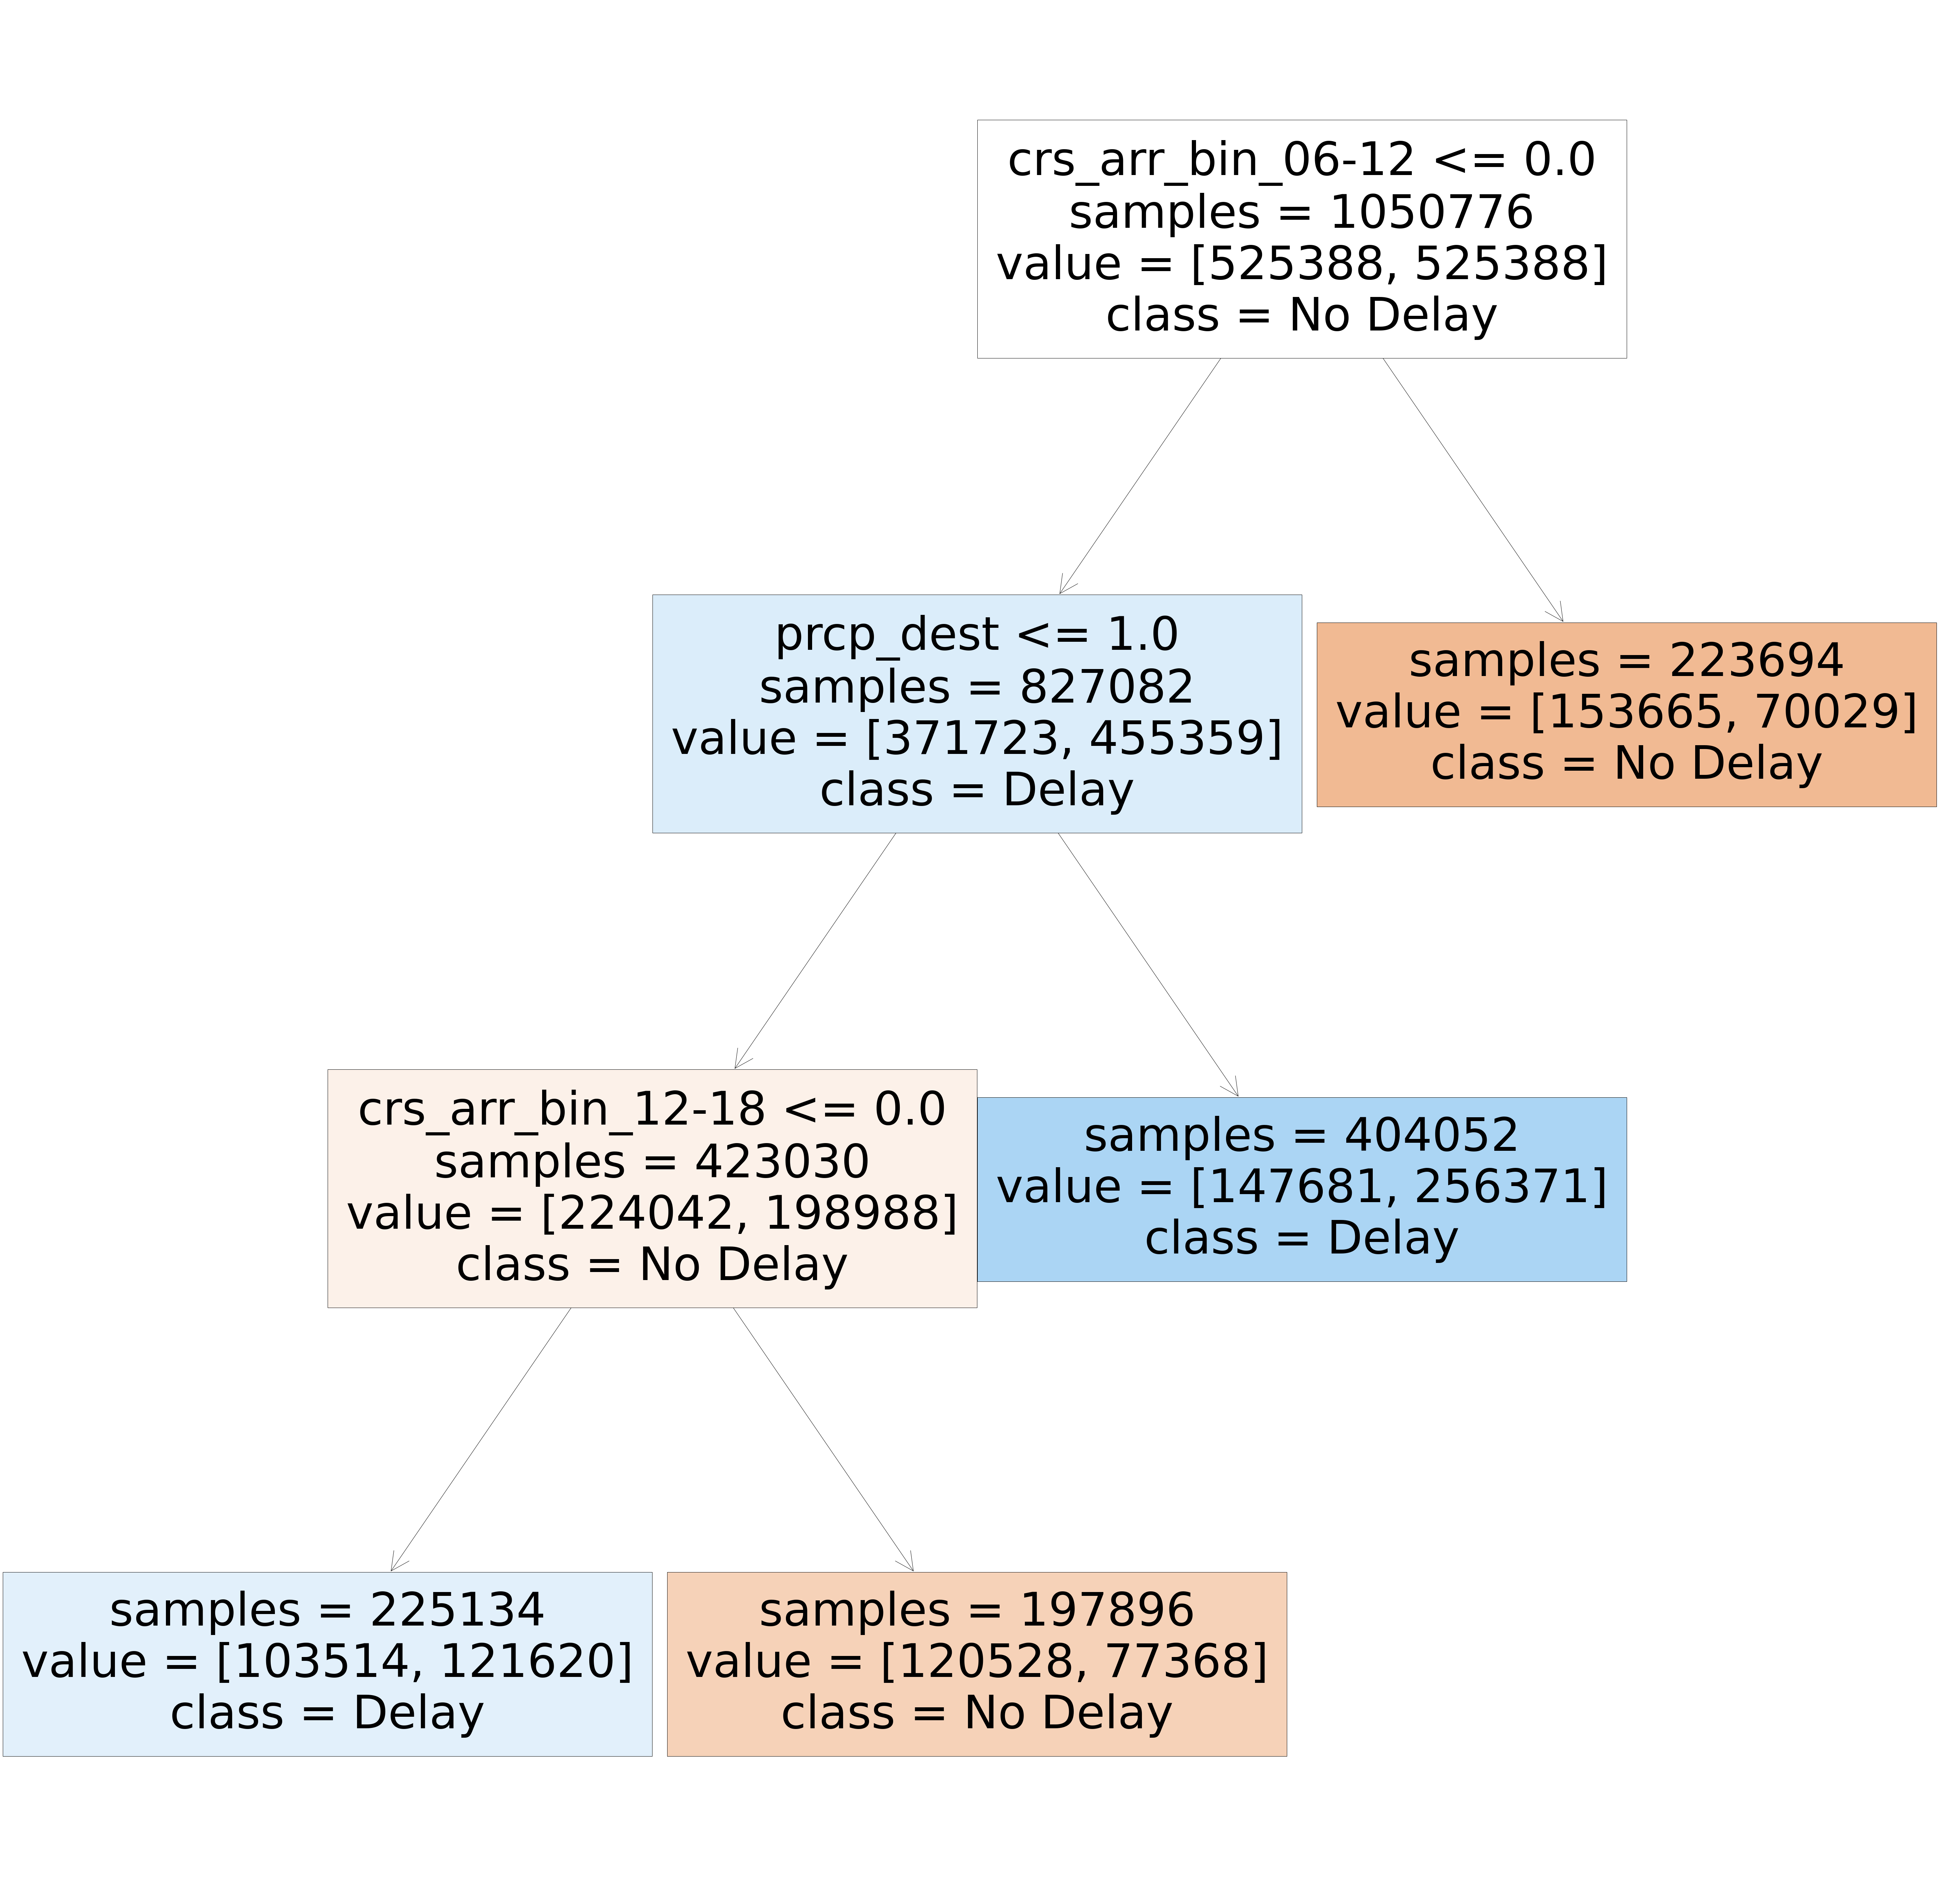

In [37]:
plt.figure(figsize = (100,100))
class_labels = ["No Delay", "Delay"]
plot_tree(dt, feature_names = X_resampled.columns, class_names = class_labels, filled = True, impurity = False, precision = 0)